In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_tensor
import cv2

In [2]:
class BoardModel(nn.Module):
    def __init__(self):
        super(BoardModel, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64, 2),
            *[ResidualBlock(64, 64) for _ in range(1)],
            ConvBlock(64, 128, 2),
            *[ResidualBlock(128, 128) for _ in range(2)],
            ConvBlock(128, 256, 2),
            *[ResidualBlock(256, 256) for _ in range(3)],
            ConvBlock(256, 128, 2),
            *[ResidualBlock(128, 128) for _ in range(2)],
            ConvBlock(128, 64, 2),
            ConvBlock(64, 32, 2),
            ConvBlock(32, 1, 1, kernel_size=(4, 2), act='sigmoid'),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.layers(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1, kernel_size=3, act=None):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=False)
        self.act = act
        if self.act != 'sigmoid':
            self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        if self.act == 'sigmoid':
            out = torch.sigmoid(self.conv(x))
            return out
        out = F.relu(self.bn(self.conv(x)))
        return out

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            self._block(3, 32, 3),
            self._block(32, 48, 3),
            self._block(48, 64, 3),
            self._block(64, 80, 3),
            self._block(80, 96, 3),
            self._block(96, 112, 3),
            self._block(112, 128, 3),
            self._block(128, 144, 3),
            self._block(144, 174, 3),
            Flatten(),
            nn.Linear(6264, 3, bias=False),
            nn.BatchNorm1d(3),
        )

    def _block(self, input_dim, output_dim, kernel_size):
        return nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size, bias=False),
            nn.BatchNorm2d(output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.seq(x)
        return F.log_softmax(x, dim=1)

class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x.permute(0, 2, 3, 1), 1)

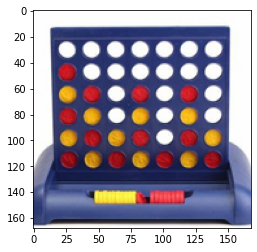

In [3]:
boardModel = BoardModel()
boardModel.load_state_dict(torch.load('connectFourBoard.pth'))
boardModel.eval()

fieldModel = Model()
fieldModel.load_state_dict(torch.load('connectFourField.pt'))
fieldModel.eval()

testImg = Image.open('proxy.jpeg')
testImg = testImg.resize((168, 168))
plt.imshow(testImg)

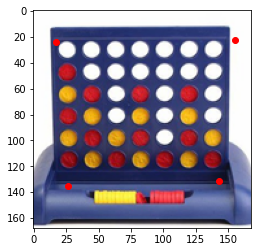

In [4]:
imgT = to_tensor(testImg)
imgT = imgT.unsqueeze(0)
outputs = boardModel(imgT)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(4, 2)
outputs = outputs * 168
plt.imshow(testImg)
plt.plot(outputs[:, 0], outputs[:, 1], 'ro')

In [5]:
x1, x2, x3, x4 = outputs[:, 0]
y1, y2, y3, y4 = outputs[:, 1]



M = cv2.getPerspectiveTransform(np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]), np.float32([(0, 0), (168, 0), (168, 144), (0, 144)]))
warped = cv2.warpPerspective(np.array(testImg), M, (168, 144))
warped = Image.fromarray(warped)

fields = []

for row in range(6):
    for column in range(7):
        cropped = warped.crop((column * (168 / 7), row * (144 / 6), (column + 1) * (168 / 7), (row + 1) * (144 / 6)))
        cropped = to_tensor(cropped)
        fields.append(cropped)

fields = torch.stack(fields)
out = fieldModel(fields)
state = out.argmax(1).numpy().reshape(6, 7)
print(state)

[[0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [1 2 0 2 0 2 0]
 [2 1 2 1 0 1 2]
 [1 2 1 2 1 2 0]
 [0 0 0 0 0 0 0]]


tensor([[9.9856e-01, 6.8708e-04, 7.4804e-04]], grad_fn=<ExpBackward0>)

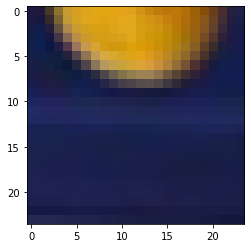

In [9]:
row = 5
column = 5
cropped = warped.crop((column * (168 / 7), row * (144 / 6), (column + 1) * (168 / 7), (row + 1) * (144 / 6)))
plt.imshow(cropped)
croppedT = to_tensor(cropped)
torch.exp(fieldModel(croppedT.reshape(1, 3, 24, 24)))